## Imports

In [1]:
from nb_utils import set_root

PROJECT_DIR = set_root(4, "src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import (LogisticRegression,
                                       RandomForestClassifier)
from pyspark.ml.evaluation import (MulticlassClassificationEvaluator,
                                   RegressionEvaluator)
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
from sklearn.datasets import fetch_california_housing, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.utils._bunch import Bunch

from mlpr.ml.supervisioned.classification.utils import generate_colors
from mlpr.ml.supervisioned.tunning.grid_search import SparkGridSearch

## Build a spark sesion

In [3]:
spark = SparkSession.builder \
    .appName("Python Spark Grid Search Analysis") \
    .getOrCreate()

24/05/13 18:00:13 WARN Utils: Your hostname, manuel-kunumi resolves to a loopback address: 127.0.1.1; using 192.168.18.131 instead (on interface wlp0s20f3)
24/05/13 18:00:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/13 18:00:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Parameters

In [4]:
random_state: int = 42
n_feats: int = 2
n_size: int = 1000
centers: list[tuple] = [
    (0, 2),
    (2, 0),
    (5, 4.5)
]
n_class: int = len(centers)
cluster_std: list[float] = [1.4, 1.4, 0.8]
cv: int = 5
np.random.seed(random_state)

In [5]:
models_params: dict[str, dict] = {
    "regression": {
        RandomForestRegressor: {"numTrees": [10, 50, 100]},
        LinearRegression: {"regParam": [0.1, 0.01]}
    },
    "classification": {
        RandomForestClassifier: {"numTrees": [10, 50, 100]},
        LogisticRegression: {"regParam": [0.1, 0.01]}
    }
}

metrics: dict[str, dict[str, dict[str, any]]] = {
    "regression": {
        "custom_rmse": {"evaluator": RegressionEvaluator(metricName="rmse"), "goal": "minimize"},
        "rmse": {"evaluator": RegressionEvaluator(metricName="rmse"), "goal": "minimize"},
        "r2": {"evaluator": RegressionEvaluator(metricName="r2"), "goal": "maximize"}
    },
    "classification": {
        "accuracy": {"evaluator": MulticlassClassificationEvaluator(metricName="accuracy"), "goal": "maximize"},
        "f1": {"evaluator": MulticlassClassificationEvaluator(metricName="f1"), "goal": "maximize"}
    }
}

In [6]:
target: str = "target"
scoring: dict[str, str] = {
    "regression": "r2",
    "classification": "accuracy"
}

In [7]:
data: dict[str, any] = {
    "regression": None,
    "classification": None
}
data_spark: dict[str, any] = data.copy()
best_models: dict[str, any] = data.copy()
best_params: dict[str, any] = data.copy()
preds: dict[str, any] = data.copy()
grid_search: dict[str, any] = data.copy()

In [8]:
params: dict[str, dict[str, any]] = {
    "n_samples": n_size,
    "n_features": n_feats,
    "centers": centers,
    "cluster_std": cluster_std,
    "random_state": random_state
}

In [9]:
params_valid: dict[str, dict[str, any]] = {
    "n_samples": 500,
    "n_features": n_feats,
    "centers": centers,
    "cluster_std": [2, 1.2, 2],
    "random_state": random_state
}

In [10]:
classification_syn: bool = True

## Load datasets

In [11]:
california: Bunch = fetch_california_housing()
breast_cancer: Bunch = load_breast_cancer()

In [12]:
content = {
    "regression": california,
    "classification": breast_cancer
}

In [13]:
data["classification"]: pd.DataFrame = pd.DataFrame(
    content["classification"].data,
    columns=content["classification"].feature_names
)
data["classification"][target]: pd.Series = pd.Series(
    content["classification"].target
)

data["regression"]: pd.DataFrame = pd.DataFrame(
    content["regression"].data,
    columns=content["regression"].feature_names
)
data["regression"][target]: pd.Series = pd.Series(
    content["regression"].target
)

In [14]:
p: float = 0.2
data_class_valid = data["classification"].sample(int(data["classification"].shape[0] * p))
data["classification"] = data["classification"].drop(data_class_valid.index, axis=0)

In [15]:
data_class_valid.shape

(113, 31)

## Transform in spark dataframe

In [16]:
data_spark["regression"]: DataFrame = spark.createDataFrame(
    data["regression"]
)

data_spark["classification"]: DataFrame = spark.createDataFrame(
    data["classification"]
)

## Regression

### Set Grid Seach for spark

In [17]:
grid_search["regression"] = SparkGridSearch(
    models_params["regression"],
    content["regression"].feature_names,
    scoring["regression"],
    model_type="regression",
    metrics=metrics["regression"]
)
grid_search["regression"].fit(
    data_spark["regression"],
    target
)

### Add custom metric

In [18]:
grid_search["regression"].add_metric("custom_rmse", lambda x: -x)

### Get best model

In [19]:
best_models["regression"], best_params["regression"] = grid_search["regression"].get_best_model()

In [20]:
preds["regression"] = best_models["regression"].transform(
    data_spark["regression"]
).toPandas()

### View dataset

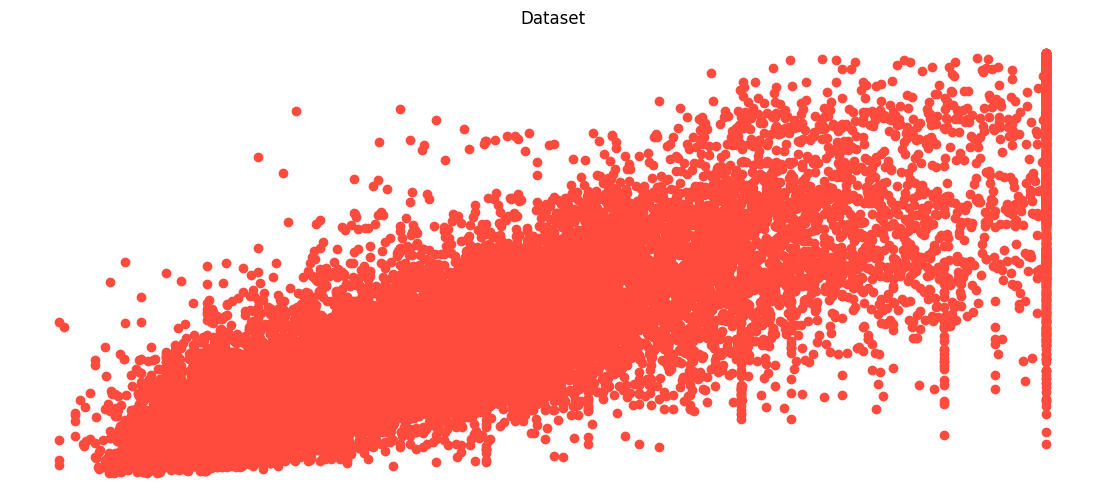

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.scatter(
    data["regression"][target],
    preds["regression"]["prediction"],
    color="#FF4B3E"
)
ax.set_title("Dataset")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Classification

### Set Grid Seach for spark

In [22]:
grid_search["classification"] = SparkGridSearch(
    models_params["classification"],
    content["classification"].feature_names,
    scoring["classification"],
    model_type="classification",
    metrics=metrics["classification"]
)
grid_search["classification"].fit(
    data_spark["classification"],
    target
)

24/05/13 18:02:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Add custom metric

In [23]:
grid_search["classification"].add_metric("custom_accuracy", lambda x: 1 - x)

### Get best model

In [24]:
best_models["classification"], best_params["classification"] = grid_search["classification"].get_best_model()

In [25]:
preds["classification"] = best_models["classification"].transform(
    data_spark["classification"]
).toPandas()

### View dataset in validation

In [26]:
X = data_class_valid.drop("target", axis=1).copy()
y = data_class_valid["target"].values

In [27]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

In [28]:
y_preds_valid = best_models["classification"].transform(
    spark.createDataFrame(data_class_valid)
).toPandas()

In [29]:
colors = generate_colors("FF4B3E", "1C2127", len(np.unique(y)))
markers = ['o', 'v', '^']

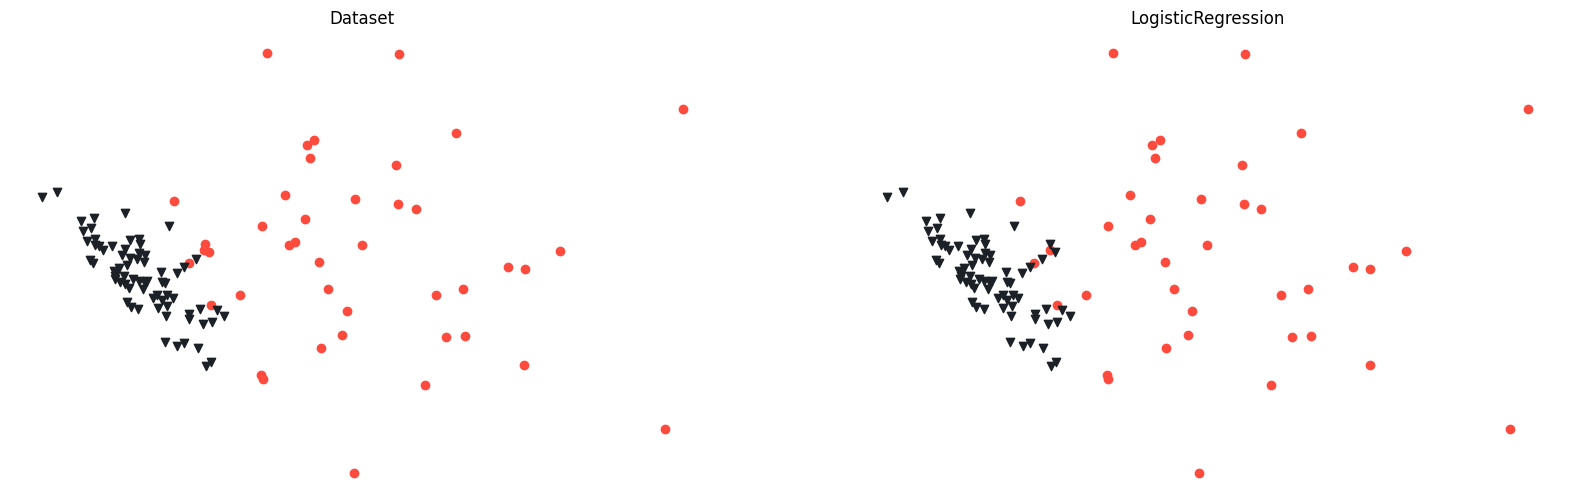

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

for i, k in enumerate(np.unique(y)):
    for _y, _ax in zip([y, y_preds_valid["prediction"]], ax):
        _ax.scatter(
            X_pca[:, 0][_y == k],
            X_pca[:, 1][_y == k],
            marker=markers[i % len(markers)],
            color=colors[i],
            label=f"c{i}"
        )

ax[0].set_title("Dataset")
ax[1].set_title(grid_search["classification"].best_model)

for _ax in ax:
    _ax.set_frame_on(False)
    _ax.set_xticks([])
    _ax.set_yticks([])

In [31]:
confusion_matrix(data_class_valid[target], y_preds_valid["prediction"])

array([[40,  2],
       [ 0, 71]])